In [1]:
import glob

import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import DataLoader

import os
from tools.GNN_model_weight.models import *
from tools.GNN_model_weight.utils_newdata import *

/mnt/storage/tmlinare/conda/envs/pytorch_py39_cu102/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the two graph datasets from .pt files
# dataset1 = torch.load("/eos/home-t/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs_NewDataset_TEST_flatmassW_2files_with_pT")
# dataset1 = torch.load("/eos/home-t/tmlinare/Lund/Lund_tagging/
# _data/graphs_NewDataset_TEST_W_2files_with_pT")
# dataset1 = torch.load("/Users/zhangzeyi/Desktop/group project/lundtoptagger/graphs_NewDataset_TEST_Wtest_files3-4_with_pT")
# dataset1 = torch.load("/Users/ian/Group Project Physics/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_Zqq_1-2_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
dataset1 = torch.load("/home/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_Zqq_1-2_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
# dataset2 = torch.load("/eos/home-t/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs_NewDataset_TEST_QCD_full_declustering_10files_with_pT")
# dataset2 = torch.load("/eos/home-t/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs_NewDataset_TEST_QCD_full_declustering_2percent4_with_pT")
# dataset2 = torch.load("/Users/zhangzeyi/Desktop/group project/graphs_QCD_ln_kT_cut_None_with_pt_with_dsids_mcweights")
# dataset2 = torch.load("/Users/ian/Group Project Physics/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_QCD_2percent4_test_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
dataset2 = torch.load("/home/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_QCD_2percent4_test_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
# dataset3 = torch.load("/Users/ian/Group Project Physics/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_Wqq_1-2_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
dataset3 = torch.load("/home/tmlinare/Lund/Lund_tagging/lundtoptagger_data/graphs/ln_kT_cut_None_with_pt_200_with_dsids_mcweights/graphs_Wqq_1-2_ln_kT_cut_None_with_pt_200_with_dsids_mcweights")
# add W

In [3]:


weight_1 = 60.9 / (2*30000)
weight_3 = 143.0 / (2*30000)

QCD_cs = np.array([7.81e+10, 7.81e+10, 2.43e+9, 2.65e+7, 2.55e+5, 4.55e+3, 258, 16.2, 0.625, 0.0196, 0.00120, 0.0000423, 0.00000104])
QCD_n_of_events = np.array([99940, 99815, 99110, 797467, 748123, 323052, 49942, 24870, 24925, 12490, 3300, 3300, 3300])
QCD_gen_filter_effeciency = np.array([0.9753263, 0.02442452, 0.009863123, 0.01165838, 0.0133656, 0.01452648, 0.009471878, 0.01109724, 0.01015436, 0.01205606, 0.005893302, 0.002673, 0.0004288923])
QCD_weights = QCD_cs / QCD_n_of_events*QCD_gen_filter_effeciency
dsids = np.array([364700, 364701, 364702, 364703, 364704, 364705, 364706, 364707, 364708, 364709, 364710, 364711, 364712])

dataset1 = [jet_graph for jet_graph in dataset1 if jet_graph.y==1]
dataset3 = [jet_graph for jet_graph in dataset3 if jet_graph.y==1]

for Z_jet in dataset1:
    Z_jet.weight = weight_1
    del Z_jet.dsid
    del Z_jet.mcEventWeight
print(len(dataset1))
print(dataset2)
# dataset1 = [jet_graph for jet_graph in dataset1 if jet_graph.pt > 500]
# dataset2 = [jet_graph for jet_graph in dataset2 if jet_graph.dsid in dsids[1:]]# and jet_graph.pt > 500]
# dataset3 = [jet_graph for jet_graph in dataset3 if jet_graph.pt > 500]

for QCD_jet in dataset2:
    ind = np.where(dsids == QCD_jet.dsid)[0][0]
    QCD_jet.weight = QCD_weights[ind] #* QCD_jet.mcEventWeight
    del QCD_jet.dsid
    del QCD_jet.mcEventWeight

for W_jet in dataset3:
    W_jet.weight = weight_3
    del W_jet.dsid
    del W_jet.mcEventWeight

# y_truth affects what i chosen as the 50% signal efficiency threshold
y_truth1 = np.array([1 for jet_graph in dataset1])
y_truth2 = np.array([0 for jet_graph in dataset2])
y_truth3 = np.array([1 for jet_graph in dataset3])

truth_particles1 = np.array(["Z" for jet_graph in dataset1])
truth_particles2 = np.array(["QCD" for jet_graph in dataset2])
truth_particles3 = np.array(["W" for jet_graph in dataset3])


# Combine them (make sure both are of the same dataset type)
combined_dataset = dataset1 + dataset2 + dataset3

y_truth = np.concatenate([y_truth1, y_truth2, y_truth3])

truth_particles = np.concatenate([truth_particles1, truth_particles2, truth_particles3])

36963


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
batch_size = 2000
test_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)

# path_to_combined_ckpt = "/eos/home-t/tmlinare/Lund/Lund_tagging/lundtoptagger_data/models/run4_W-2files_QCD-2percent/LundNet_R22_ExtraNode_ln_kT_Cut_0.0_LRJ_NewData_Primarye035_0.25286.pt"
models = {
    "LundNet on wide-mass W": {
        "path_to_ckpt": "/home/tmlinare/Lund/Lund_tagging/lundtoptagger_data/models/Ian GPU same total weight for signal and background/LundNet_R22_ExtraNode_ln_kT_Cut_None_LRJ_NewData_Primary_e019_0.15039.pt"
        #"/Users/zhangzeyi/Desktop/group project/results/LundNet_R22_ExtraNode_No_ln_kT_Cut_LRJ_NewData_Primarye010_0.20520.pt"
    },
    # "LundNet on regular W": {
    #     "path_to_ckpt": "/Users/zhangzeyi/Desktop/group project/LundNet_R22_ExtraNode_ln_kT_Cut_None_LRJ_NewData_Primarye016_0.08727.pt"
    # },
    # "LundNet on Z": {
    #     "path_to_ckpt": "/Users/zhangzeyi/Desktop/group project/results/Z data/LundNet_R22_ExtraNode_ln_kT_Cut_{ln_kT_cut}_LRJ_NewData_Primary_e015_0.10772.pt"
    # },
    "LundNet on W_Z": {
        "path_to_ckpt": "/home/tmlinare/Lund/Lund_tagging/lundtoptagger_data/models/Ian GPU same total weight for signal and background/LundNet_R22_ExtraNode_ln_kT_Cut_None_LRJ_NewData_Primary_e019_0.15039.pt_e023_0.10136.pt"
    }
}

for trained_model in models:
    model = LundNet()
    path_to_combined_ckpt = models[trained_model]["path_to_ckpt"]
    model.load_state_dict(torch.load(path_to_combined_ckpt, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #Predict scores
    models[trained_model]["y_pred"] = get_scores(test_loader, model, device)[:,0]

/mnt/storage/tmlinare/conda/envs/pytorch_py39_cu102/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/mnt/storage/tmlinare/conda/envs/pytorch_py39_cu102/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


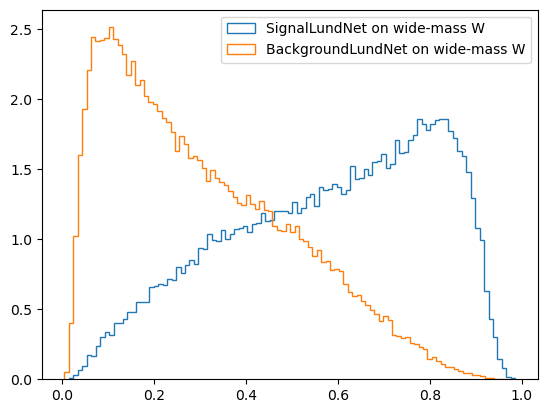

[0.54586792 0.81921113 0.37820819 ... 0.1688581  0.29166579 0.63602263]
50% signal efficiency working point for the tagger score: 0.6626654863357544


In [ ]:
# Get the indices of signal events
signal_selection = y_truth == 1

for trained_model in models:
    if trained_model == "LundNet on W_Z":
        continue
    y_pred = models[trained_model]["y_pred"]

    plt.hist(y_pred[signal_selection], bins=100, histtype='step', label='Signal'+trained_model, density=True)
    plt.hist(y_pred[y_truth==0], bins=100, histtype='step', label='Background'+trained_model, density=True)
    plt.legend()

    # Get the tagger scores for signal events
    signal_scores = y_pred[signal_selection]

    # Sort the signal scores in descending order
    sorted_signal_scores = np.sort(signal_scores)[::-1]

    # Find the score at the 50% signal efficiency point
    threshold_index = int(0.5 * len(sorted_signal_scores))
    threshold_score = sorted_signal_scores[threshold_index]
    #threshold_score = 0.6
    tagged_as_signal = y_pred > threshold_score
    models[trained_model]["tagged_as_signal"] = tagged_as_signal
    models[trained_model]["threshold_score"] = threshold_score
plt.show()

signal_selection = (truth_particles == "Z") & models["LundNet on wide-mass W"]["tagged_as_signal"]

y_pred = models["LundNet on W_Z"]["y_pred"]
print(y_pred)
# plt.hist(y_pred[signal_selection], bins=100, histtype='step', label='Signal'+trained_model, density=True)
# plt.hist(y_pred[~signal_selection], bins=100, histtype='step', label='Background'+trained_model, density=True)
# plt.legend()

# Get the tagger scores for signal events
signal_scores = y_pred[signal_selection]

# Sort the signal scores in descending order
sorted_signal_scores = np.sort(signal_scores)[::-1]

# Find the score at the 50% signal efficiency point
threshold_index = int(0.5 * len(sorted_signal_scores))
threshold_score = sorted_signal_scores[threshold_index]
#threshold_score = 0.6
tagged_as_signal = y_pred > threshold_score
models["LundNet on W_Z"]["tagged_as_signal"] = tagged_as_signal
models["LundNet on W_Z"]["threshold_score"] = threshold_score

print("50% signal efficiency working point for the tagger score:", threshold_score)


In [6]:
sum(truth_particles == "Z") 

36963

In [7]:
models["LundNet on wide-mass W"]["tagged_as_signal"]

array([ True, False,  True, ...,  True,  True, False])

In [8]:
var_params = {
    "LRJ_mass": {"graph_name": "mass", "title": "LRJ mass [GeV]",  "bins": 30, "range": (0, 200) },
    "LRJ_pt":   {"graph_name": "pt",   "title": "LRJ $p_T$ [GeV]", "bins": 30, "range": (0, 3000)},
}
# truth_labels = [2]  # truth labels to plot
# data = {var: ak.flatten(analysis_tree[var].array()) for var in var_params}

In [9]:
samples = ["W", "Z", "QCD", "combined"]
#samples = ["Z", "QCD", "combined"]
#samples = ["W", "QCD", "combined"]
#samples = ["W", "Z", "QCD"]
combined_sample_list = [s for s in samples if s != "combined"]
#combined_sample_list = [s for s in samples if s in ["Z", "QCD"]]
#linestyles = [":", "--", "-"]
linestyles = [":", "--", "-", "-."]


In [10]:
mass_cut_counts = {}

Mass cut 80.0: lower than cut = 13.947266666666668, greater than cut = 29.672500000000003, W, tagged as signal with 50% efficiency (trained on wide-mass W)
Mass cut 81.03448275862068: lower than cut = 15.596533333333337, greater than cut = 28.023233333333337, W, tagged as signal with 50% efficiency (trained on wide-mass W)
Mass cut 82.06896551724138: lower than cut = 17.324450000000002, greater than cut = 26.295316666666672, W, tagged as signal with 50% efficiency (trained on wide-mass W)
Mass cut 83.10344827586206: lower than cut = 19.00946666666667, greater than cut = 24.610300000000002, W, tagged as signal with 50% efficiency (trained on wide-mass W)
Mass cut 84.13793103448276: lower than cut = 20.873233333333335, greater than cut = 22.746533333333335, W, tagged as signal with 50% efficiency (trained on wide-mass W)
Mass cut 85.17241379310344: lower than cut = 22.608300000000003, greater than cut = 21.01146666666667, W, tagged as signal with 50% efficiency (trained on wide-mass W)
M

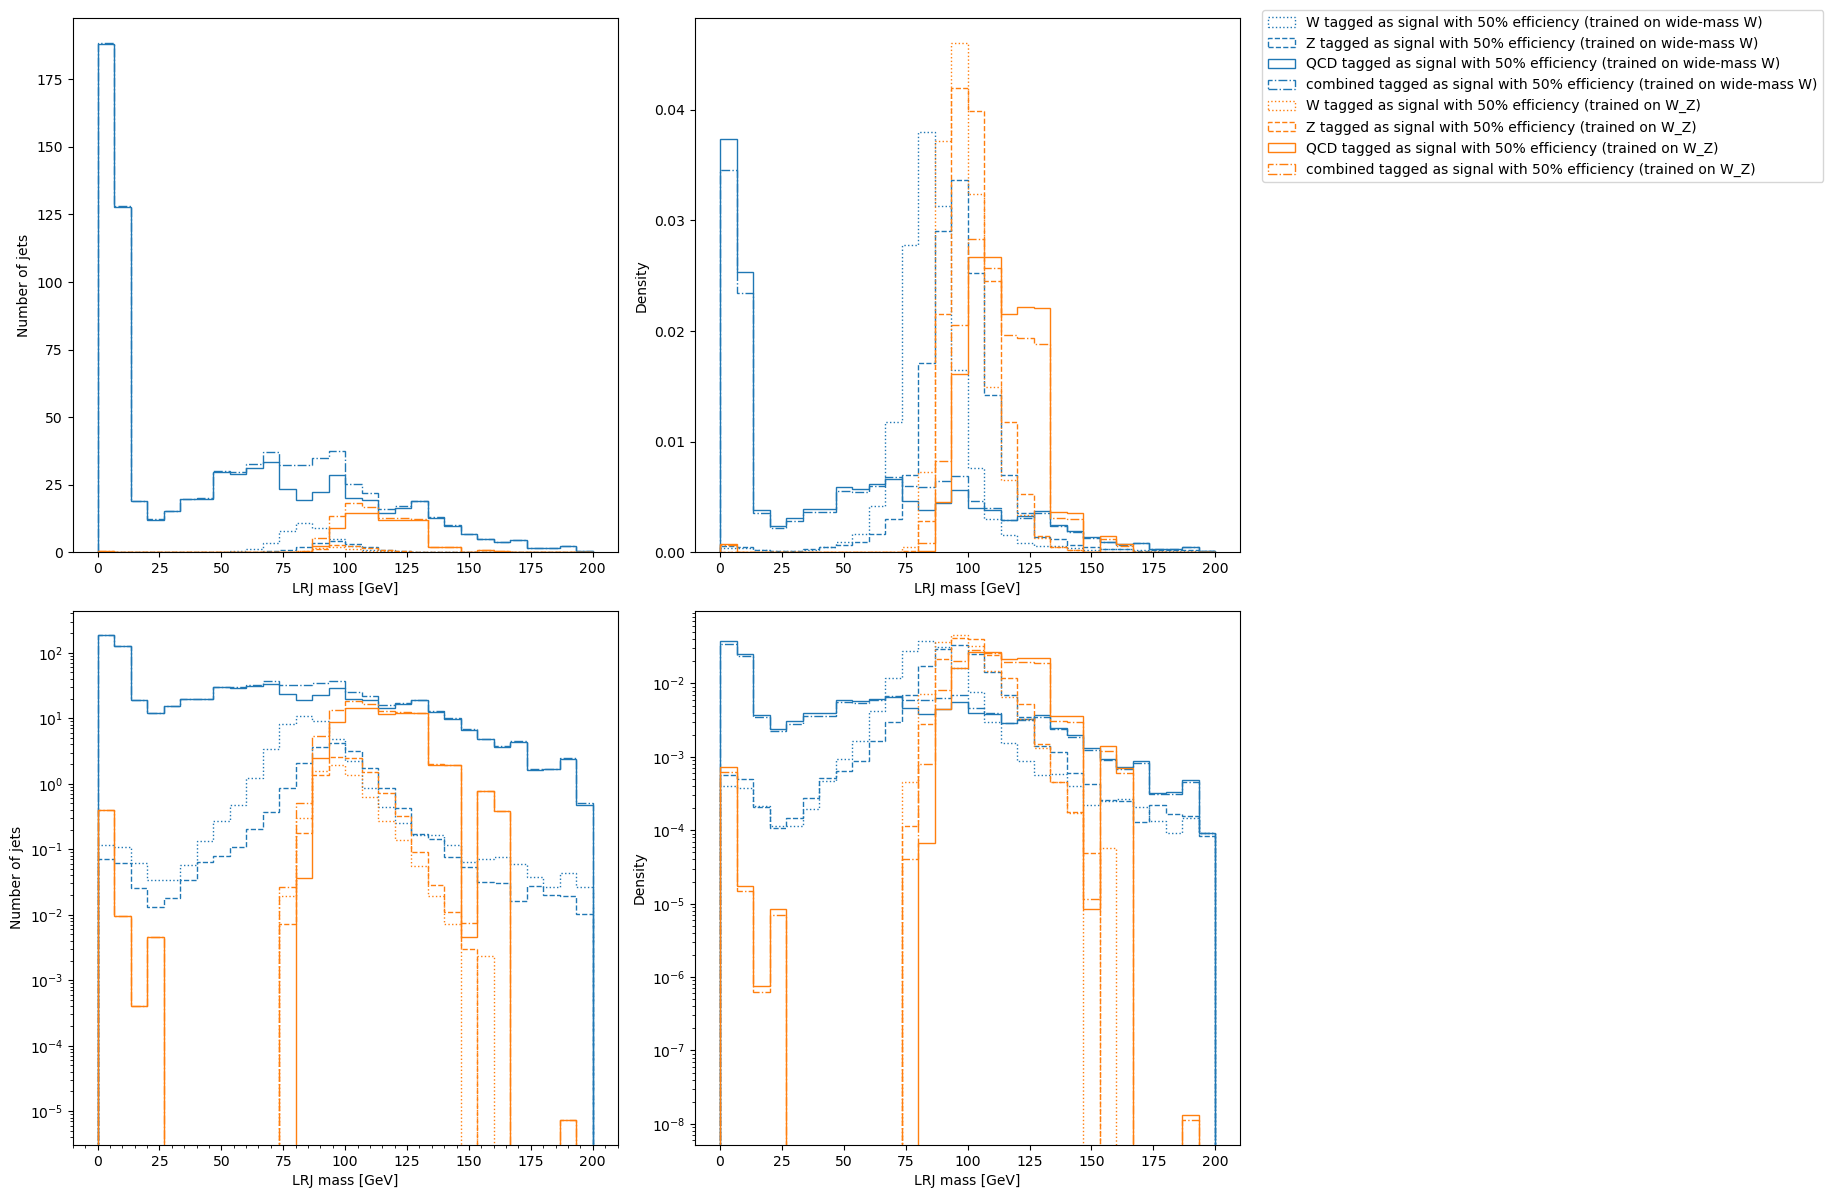

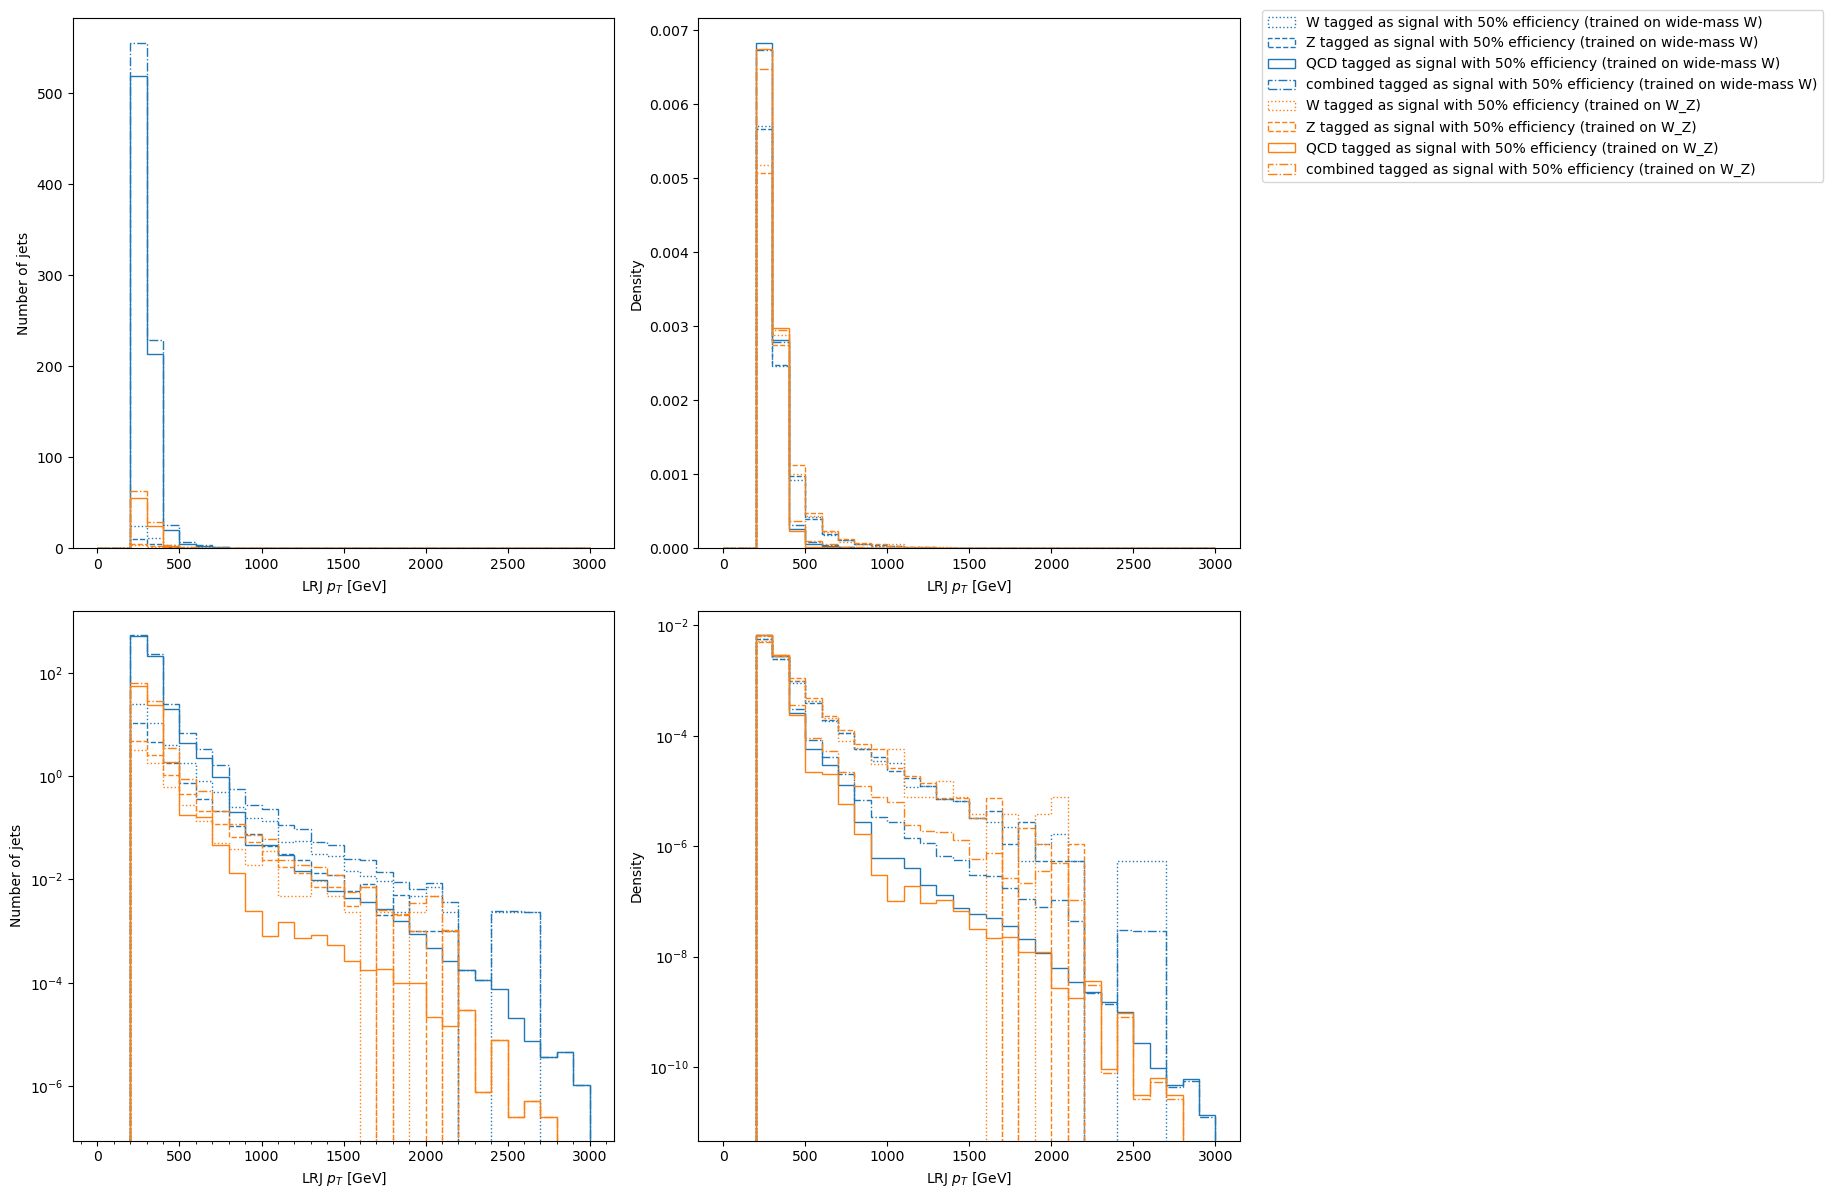

In [11]:
for var in var_params:
    xlabel = var_params[var]["title"]
    hist_args = {
        "bins": var_params[var]["bins"],
        "range": var_params[var]["range"],
        "histtype": "step"
    }

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # We will collect handles/labels from each subplot
    for color_n, stage in enumerate([
        #"before cuts",
        #"tagger input",
        "tagged as signal with 50% efficiency (trained on wide-mass W)",
        #"tagged as signal with 50% efficiency (trained on regular W)",
        #"tagged as signal with 50% efficiency (trained on Z)",
        "tagged as signal with 50% efficiency (trained on W_Z)"
    ]):
        hist_args["color"] = f"C{color_n}"

        if stage == "before cuts":
            arrays = []
            for file_path in files:
                file = uproot.open(file_path)
                analysis_tree = file["AnalysisTree"]
                arrays.append(ak.flatten(analysis_tree[var].array()))
            data_var = ak.concatenate(arrays)
            tagged_as_signal = LRJ_truthLabel
        else:
            data_var = np.array([data[var_params[var]["graph_name"]] for data in combined_dataset])
            weights = np.array([data.weight for data in combined_dataset])
            if stage == "tagger input":
                tagged_as_signal = np.full_like(truth_particles, fill_value=True, dtype=bool)
            elif stage == "tagged as signal with 50% efficiency (trained on wide-mass W)":
                tagged_as_signal = models["LundNet on wide-mass W"]["tagged_as_signal"]
            elif stage == "tagged as signal with 50% efficiency (trained on regular W)":
                tagged_as_signal = models["LundNet on regular W"]["tagged_as_signal"]
            elif stage == "tagged as signal with 50% efficiency (trained on Z)":
                tagged_as_signal = models["LundNet on Z"]["tagged_as_signal"]
            elif stage == "tagged as signal with 50% efficiency (trained on W_Z)":
                tagged_as_signal = models["LundNet on W_Z"]["tagged_as_signal"] & models["LundNet on wide-mass W"]["tagged_as_signal"] #(~models["LundNet on W_Z"]["tagged_as_signal"])
        if stage == "tagged as signal with 50% efficiency (trained on wide-mass W)" and var == "LRJ_mass":
            mass_cut_counts = {}
        for sample,linestyle in zip(samples, linestyles):
            # Create a mask using sample_labels for both data_var and weights
            if sample == "combined":
                mask = tagged_as_signal
                sample_selection = np.full_like(truth_particles, fill_value=False, dtype=bool)
                for combined_sample in combined_sample_list:
                    sample_selection = sample_selection | (truth_particles == combined_sample)
                mask = mask & sample_selection
            else:
                mask = tagged_as_signal & (truth_particles == sample)
            data_var_sample = data_var[mask]
            sample_weights = weights[mask]
            
            legend_label = f"{sample} {stage}"
            hist_args["linestyle"] = linestyle
            if stage == "tagged as signal with 50% efficiency (trained on wide-mass W)" and var == "LRJ_mass":
                mass_cut_counts[sample+"lower"] = []
                mass_cut_counts[sample+"greater"] = []
                mass_cuts = np.linspace(80, 110, 30)
                for cut in mass_cuts:
                    lower_count = np.sum(sample_weights[data_var_sample < cut])
                    greater_count = np.sum(sample_weights[data_var_sample > cut])
                    if stage != "tagger input":
                        print(f"Mass cut {cut}: lower than cut = {lower_count}, greater than cut = {greater_count}, {sample}, {stage}")
                        mass_cut_counts[sample+"lower"].append(lower_count)
                        mass_cut_counts[sample+"greater"].append(greater_count)
            # TODO: don't calculate histogram 4 times, it should be done only once, only need to vary y scale and normalisation
            
            axs[0, 0].hist(data_var_sample, label=legend_label, weights=sample_weights, **hist_args)
            axs[0, 0].set_xlabel(xlabel)
            axs[0, 0].set_ylabel("Number of jets")

            axs[0, 1].hist(data_var_sample, label=legend_label, weights=sample_weights, **hist_args, density=True)
            axs[0, 1].set_xlabel(xlabel)
            axs[0, 1].set_ylabel("Density")

            axs[1, 0].hist(data_var_sample, label=legend_label, weights=sample_weights, **hist_args)
            axs[1, 0].set_xlabel(xlabel)
            axs[1, 0].set_ylabel("Number of jets")
            axs[1, 0].set_yscale("log")
            # axs[1, 0].set_xlim(70, 120)
            axs[1, 0].minorticks_on()
            #axs[1, 0].grid(True, which='both', linestyle=':', linewidth=0.5)


            axs[1, 1].hist(data_var_sample, label=legend_label, weights=sample_weights, **hist_args, density=True)
            axs[1, 1].set_xlabel(xlabel)
            axs[1, 1].set_ylabel("Density")
            axs[1, 1].set_yscale("log")

    # Collect all handles and labels for a single legend
    handles0, labels0 = axs[0, 0].get_legend_handles_labels()
    handles1, labels1 = axs[0, 1].get_legend_handles_labels()
    handles2, labels2 = axs[1, 0].get_legend_handles_labels()
    handles3, labels3 = axs[1, 1].get_legend_handles_labels()

    all_handles = handles0 + handles1 + handles2 + handles3
    all_labels = labels0 + labels1 + labels2 + labels3

    # Remove duplicates by making a dict keyed by label
    unique_dict = dict(zip(all_labels, all_handles))
    fig.legend(unique_dict.values(), unique_dict.keys(), loc="upper left", bbox_to_anchor=(1.05, 1))

    # Adjust layout so legend does not overlap
    plt.tight_layout(rect=[0, 0, 1.05, 1])
    plt.show()

In [12]:
if "Wlower" in mass_cut_counts:
    for i,mass_cut in enumerate(mass_cuts):
        significance = mass_cut_counts["Wlower"][i] / np.sqrt(mass_cut_counts["combinedlower"][i])
        print(f"Significance of mass cut {mass_cut}: {significance}")

Significance of mass cut 80.0: 0.5870241293166617
Significance of mass cut 81.03448275862068: 0.653325710053637
Significance of mass cut 82.06896551724138: 0.7214754266364498
Significance of mass cut 83.10344827586206: 0.7891968348887057
Significance of mass cut 84.13793103448276: 0.8628692312883233
Significance of mass cut 85.17241379310344: 0.9313712694467507
Significance of mass cut 86.20689655172414: 0.9951158507868828
Significance of mass cut 87.24137931034483: 1.0577586955073501
Significance of mass cut 88.27586206896552: 1.115508277623705
Significance of mass cut 89.3103448275862: 1.1743919385907047
Significance of mass cut 90.34482758620689: 1.225827279155761
Significance of mass cut 91.37931034482759: 1.2733149584042376
Significance of mass cut 92.41379310344828: 1.3144580767074123
Significance of mass cut 93.44827586206897: 1.3561051120911805
Significance of mass cut 94.48275862068965: 1.3880913184088304
Significance of mass cut 95.51724137931035: 1.4142328368032195
Significa

In [13]:
# Significance of mass cut 90.0: 1.676359314691763
# Significance of mass cut 91.05263157894737: 1.704692611397635
# Significance of mass cut 92.10526315789474: 1.7272590229298
# Significance of mass cut 93.15789473684211: 1.7401784638787685
# Significance of mass cut 94.21052631578948: 1.7476602568324875
# Significance of mass cut 95.26315789473684: 1.7614369176082338
# Significance of mass cut 96.3157894736842: 1.7703455253645306
# Significance of mass cut 97.36842105263158: 1.7740589155815267
# Significance of mass cut 98.42105263157895: 1.780882406521603
# Significance of mass cut 99.47368421052632: 1.7822302112497066
# Significance of mass cut 100.52631578947368: 1.7840594581552944
# Significance of mass cut 101.57894736842105: 1.787076115627473
# Significance of mass cut 102.63157894736842: 1.7880483772640359
# Significance of mass cut 103.6842105263158: 1.792156869066935 (this is the mass cut for W)
# Significance of mass cut 104.73684210526315: 1.7905157859608019
# Significance of mass cut 105.78947368421052: 1.7921740527227714
# Significance of mass cut 106.84210526315789: 1.7903950344990682
# Significance of mass cut 107.89473684210526: 1.7873475164323416
# Significance of mass cut 108.94736842105263: 1.7870832044706837
# Significance of mass cut 110.0: 1.787263762645853

In [14]:
if "Zgreater" in mass_cut_counts:
    for i,mass_cut in enumerate(mass_cuts):
        significance = mass_cut_counts["Zgreater"][i] / np.sqrt(mass_cut_counts["combinedgreater"][i])
        print(f"Significance of mass cut {mass_cut}: {significance}")

Significance of mass cut 80.0: 1.0385868449725724
Significance of mass cut 81.03448275862068: 1.0351027591890403
Significance of mass cut 82.06896551724138: 1.033230202582283
Significance of mass cut 83.10344827586206: 1.0205841286268216
Significance of mass cut 84.13793103448276: 1.0087310805314333
Significance of mass cut 85.17241379310344: 0.9940886734354645
Significance of mass cut 86.20689655172414: 0.9777830131073286
Significance of mass cut 87.24137931034483: 0.9583040870612117
Significance of mass cut 88.27586206896552: 0.9395463107464309
Significance of mass cut 89.3103448275862: 0.9141464798775533
Significance of mass cut 90.34482758620689: 0.8865212072803681
Significance of mass cut 91.37931034482759: 0.8569914432038196
Significance of mass cut 92.41379310344828: 0.8284673558155766
Significance of mass cut 93.44827586206897: 0.7946377335034785
Significance of mass cut 94.48275862068965: 0.7573234071612093
Significance of mass cut 95.51724137931035: 0.7215544789101024
Signifi

In [15]:
# Significance of mass cut 50.0: 0.5070719444331272
# Significance of mass cut 51.016949152542374: 0.5071964067782064
# Significance of mass cut 52.03389830508475: 0.5075990074542912
# Significance of mass cut 53.05084745762712: 0.5078838790342393
# Significance of mass cut 54.067796610169495: 0.5079077591989084
# Significance of mass cut 55.08474576271186: 0.5082963256425465
# Significance of mass cut 56.101694915254235: 0.5077174061121826
# Significance of mass cut 57.11864406779661: 0.5080341073526279
# Significance of mass cut 58.13559322033898: 0.5081393768960238 the mass cut for Z
# Significance of mass cut 59.152542372881356: 0.5078832687035396
# Significance of mass cut 60.16949152542373: 0.5074026132880445
# Significance of mass cut 61.186440677966104: 0.5065818856529254
# Significance of mass cut 62.20338983050847: 0.5057773888572304
# Significance of mass cut 63.22033898305085: 0.505203826231187
# Significance of mass cut 64.23728813559322: 0.5035695446438266
# Significance of mass cut 65.25423728813558: 0.5009320186612573
# Significance of mass cut 66.27118644067797: 0.49906061212027436
# Significance of mass cut 67.28813559322035: 0.49696556939788294
# Significance of mass cut 68.30508474576271: 0.4942736807557462
# Significance of mass cut 69.32203389830508: 0.49125739065374907
# Significance of mass cut 70.33898305084746: 0.4883586084525012
# Significance of mass cut 71.35593220338983: 0.4851752511743833
# Significance of mass cut 72.37288135593221: 0.4804650455651823
# Significance of mass cut 73.38983050847457: 0.47665985308805564
# Significance of mass cut 74.40677966101694: 0.4710496672310295
# ...
# Significance of mass cut 106.94915254237287: 0.08065724800523918
# Significance of mass cut 107.96610169491525: 0.07480096248408981
# Significance of mass cut 108.98305084745763: 0.07008339707105243
# Significance of mass cut 110.0: 0.0656291190568811

In [90]:
combined_sample_list = ["W", "Z", "QCD"]
mass = np.array([jet_graph["mass"] for jet_graph in combined_dataset])
mass_cut = (mass > 60) & (mass < 120)
#mass_cut = None
y_truth_mass_cut = y_truth if mass_cut is None else y_truth[mass_cut]
truth_particles_mass_cut = truth_particles if mass_cut is None else truth_particles[mass_cut]
sample_weights = np.array([data.weight for data in combined_dataset])
sample_weights_mass_cut = sample_weights if mass_cut is None else sample_weights[mass_cut]

In [91]:
models.keys()

dict_keys(['LundNet on wide-mass W', 'LundNet on W_Z'])

In [92]:
# signals = ["W", "W", "Z", "W_Z"]
# model_list = ["LundNet on wide-mass W", "LundNet on regular W", "LundNet on Z", "LundNet on W_Z"]

signals = ["W", "W_Z"]
# model_list = ["LundNet on wide-mass W", "LundNet on W_Z"]
model_list = ["LundNet on wide-mass W"]


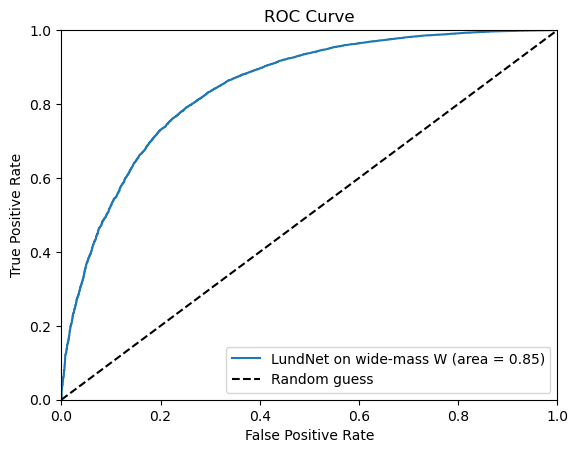

[0.70902091 0.59568584 0.7742027  ... 0.8912735  0.82764226 0.50136942]


In [93]:
from sklearn.metrics import roc_curve, auc

for trained_model,signal in zip(model_list, signals):
    if trained_model == "LundNet on wide-mass W":
        mask = np.array([ True for i in range(len(y_truth_mass_cut))])
    if trained_model == "LundNet on W_Z":
        mask = np.array([ True for i in range(len(y_truth_mass_cut))])
        
    
    y_pred = models[trained_model]["y_pred"]
    y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]
    fpr, tpr, thresholds = roc_curve(y_truth_mass_cut[mask], y_pred_mass_cut[mask], sample_weight=sample_weights_mass_cut[mask])
    roc_auc = auc(fpr, tpr)

    models[trained_model]["fpr"] = fpr
    models[trained_model]["tpr"] = tpr

    plt.plot(fpr, tpr, label=f"{trained_model} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "--", label="Random guess", color="black")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

print(y_pred)



/tmp/ipykernel_24441/3617422441.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, label=f"{trained_model}")


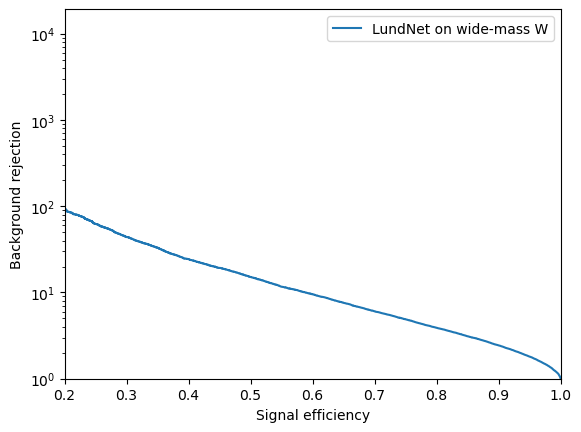

In [44]:
for trained_model in model_list:
    fpr = models[trained_model]["fpr"]
    tpr = models[trained_model]["tpr"]
    plt.plot(tpr, 1/fpr, label=f"{trained_model}")

plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.xlim([0.2, 1])
plt.ylim([1, None])
plt.yscale("log")
plt.legend()
plt.show()

/tmp/ipykernel_24441/571162681.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)
/tmp/ipykernel_24441/571162681.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)
/tmp/ipykernel_24441/571162681.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)
/tmp/ipykernel_24441/571162681.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)
/tmp/ipykernel_24441/571162681.py:37: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)


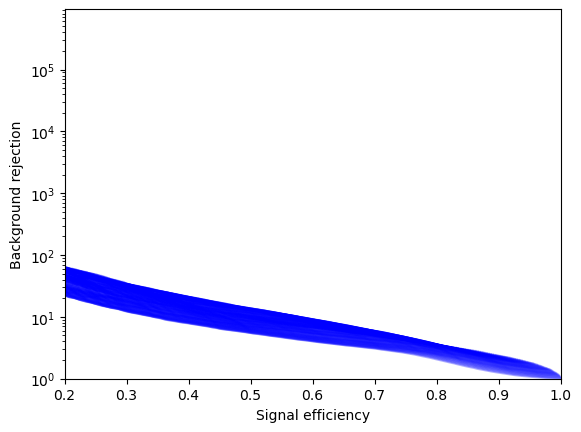

In [94]:
y_truth_only_Z_signal = np.array([1 if truth_particle=="Z" else 0 for truth_particle in truth_particles])
y_truth_only_Z_signal = y_truth_only_Z_signal if mass_cut is None else y_truth_only_Z_signal[mass_cut]
trained_model = "LundNet on wide-mass W"
y_pred = models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]
fpr, tpr, thresholds = roc_curve(y_truth_only_Z_signal, y_pred_mass_cut, sample_weight=sample_weights_mass_cut)
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
fpr = fpr[indices]
tpr = tpr[indices]
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

for i,threshold_score in enumerate(thresholds):
    # Filter y_pred values greater than the threshold score
    y_truth_signal_jets = y_truth_only_Z_signal[y_pred_mass_cut > threshold_score]
    if len(y_truth_signal_jets) == 0:
        continue
        
    trained_model = "LundNet on W_Z"
    y_pred_WZ = models[trained_model]["y_pred"]
    y_pred_WZ_mass_cut = y_pred_WZ if mass_cut is None else y_pred_WZ[mass_cut]
    y_pred_WZ_mass_cut = y_pred_WZ_mass_cut[y_pred_mass_cut > threshold_score]

    fpr_WZ, tpr_WZ, thresholds_WZ = roc_curve(y_truth_signal_jets, y_pred_WZ_mass_cut, sample_weight=sample_weights_mass_cut[y_pred_mass_cut > threshold_score])
    # Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
    indices = np.linspace(0, len(fpr_WZ) - 1, 200, dtype=int)
    fpr_WZ = fpr_WZ[indices]
    tpr_WZ = tpr_WZ[indices]
    thresholds_WZ = thresholds_WZ[indices]

    tpr_total = tpr_WZ * tpr[i]
    fpr_total = fpr_WZ * fpr[i]
    
    if fpr[i] == 0:
        continue
    plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})", color="blue", alpha=0.3)

plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.xlim([0.2, 1])
plt.ylim([1, None])
plt.yscale("log")
plt.show()

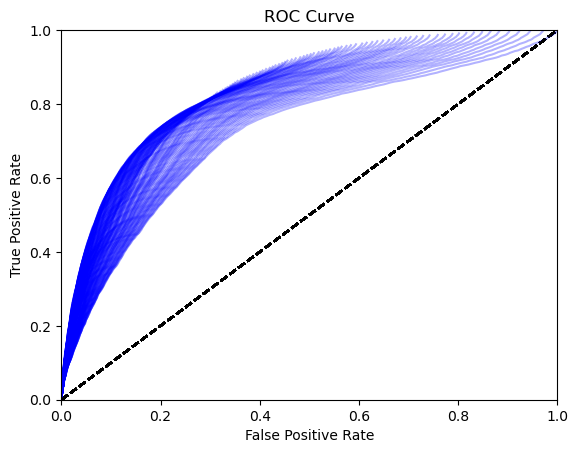

In [95]:
y_truth_only_Z_signal = np.array([1 if truth_particle=="Z" else 0 for truth_particle in truth_particles])
y_truth_only_Z_signal = y_truth_only_Z_signal if mass_cut is None else y_truth_only_Z_signal[mass_cut]
trained_model = "LundNet on wide-mass W"
y_pred = models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]
fpr, tpr, thresholds = roc_curve(y_truth_only_Z_signal, y_pred_mass_cut, sample_weight=sample_weights_mass_cut)
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
fpr = fpr[indices]
tpr = tpr[indices]
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

for i,threshold_score in enumerate(thresholds):
    # Filter y_pred values greater than the threshold score
    y_truth_signal_jets = y_truth_only_Z_signal[y_pred_mass_cut > threshold_score]
    if len(y_truth_signal_jets) == 0:
        continue
        
    trained_model = "LundNet on W_Z"
    y_pred_WZ = models[trained_model]["y_pred"]
    y_pred_WZ_mass_cut = y_pred_WZ if mass_cut is None else y_pred_WZ[mass_cut]
    y_pred_WZ_mass_cut = y_pred_WZ_mass_cut[y_pred_mass_cut > threshold_score]

    fpr_WZ, tpr_WZ, thresholds_WZ = roc_curve(y_truth_signal_jets, y_pred_WZ_mass_cut, sample_weight=sample_weights_mass_cut[y_pred_mass_cut > threshold_score])
    # Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
    indices = np.linspace(0, len(fpr_WZ) - 1, 200, dtype=int)
    fpr_WZ = fpr_WZ[indices]
    tpr_WZ = tpr_WZ[indices]
    thresholds_WZ = thresholds_WZ[indices]


    tpr_total = tpr_WZ * tpr[i]
    fpr_total = fpr_WZ * fpr[i]
    
    plt.plot(fpr_total, tpr_total, label=f"{trained_model} (area = {roc_auc:.2f})" ,color="blue", alpha=0.3)

    plt.plot([0, 1], [0, 1], "--", label="Random guess", color="black")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
#plt.legend(loc="lower right")
plt.show()
    


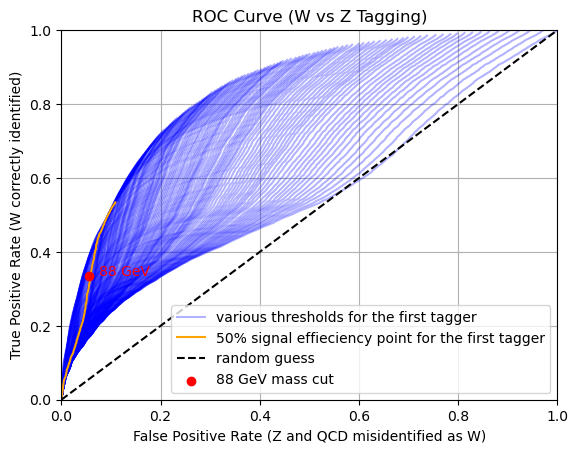

In [99]:
y_truth_only_Z_signal = np.array([1 if truth_particle=="W" else 0 for truth_particle in truth_particles])
y_truth_only_Z_signal = y_truth_only_Z_signal if mass_cut is None else y_truth_only_Z_signal[mass_cut]
trained_model = "LundNet on wide-mass W"
y_pred = models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]
fpr, tpr, thresholds = roc_curve(y_truth_only_Z_signal, y_pred_mass_cut, sample_weight=sample_weights_mass_cut)
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
fpr = fpr[indices]
tpr = tpr[indices]
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

for i,threshold_score in enumerate(thresholds):
    # Filter y_pred values greater than the threshold score
    y_truth_signal_jets = y_truth_only_Z_signal[y_pred_mass_cut > threshold_score]
    if len(y_truth_signal_jets) == 0:
        continue
        
    trained_model = "LundNet on W_Z"
    y_pred_WZ = 1-models[trained_model]["y_pred"]
    y_pred_WZ_mass_cut = y_pred_WZ if mass_cut is None else y_pred_WZ[mass_cut]
    y_pred_WZ_mass_cut = y_pred_WZ_mass_cut[y_pred_mass_cut > threshold_score]

    fpr_WZ, tpr_WZ, thresholds_WZ = roc_curve(y_truth_signal_jets, y_pred_WZ_mass_cut, sample_weight=sample_weights_mass_cut[y_pred_mass_cut > threshold_score])
    # Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
    indices = np.linspace(0, len(fpr_WZ) - 1, 200, dtype=int)
    fpr_WZ = fpr_WZ[indices]
    tpr_WZ = tpr_WZ[indices]
    thresholds_WZ = thresholds_WZ[indices]

    tpr_total = tpr_WZ * tpr[i]
    fpr_total = fpr_WZ * fpr[i]
    
    varied_score_cut_lines, = plt.plot(fpr_total, tpr_total, label=f"{trained_model} (area = {roc_auc:.2f})" ,color="blue", alpha=0.3)
y_truth_W_signal = np.array([1 if truth_particle == "W" else 0 for truth_particle in truth_particles])
y_truth_W_signal_mass_cut = y_truth_W_signal if mass_cut is None else y_truth_W_signal[mass_cut]
tagged_as_signal = models["LundNet on wide-mass W"]["tagged_as_signal"] if mass_cut is None else models["LundNet on wide-mass W"]["tagged_as_signal"][mass_cut]

trained_model = "LundNet on W_Z"
y_pred = 1-models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]


fpr, tpr, thresholds = roc_curve(y_truth_W_signal_mass_cut[tagged_as_signal], y_pred_mass_cut[tagged_as_signal], sample_weight=sample_weights_mass_cut[tagged_as_signal])
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
sample_weights_mass_cut_tagged_as_signal = sample_weights_mass_cut[tagged_as_signal]
tpr_first_tagger = np.sum(sample_weights_mass_cut_tagged_as_signal[y_truth_W_signal_mass_cut[tagged_as_signal] == 1]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 1])
fpr_first_tagger = np.sum(sample_weights_mass_cut_tagged_as_signal[y_truth_W_signal_mass_cut[tagged_as_signal] == 0]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 0])
fpr = fpr[indices]*fpr_first_tagger
tpr = tpr[indices]*tpr_first_tagger
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

# Apply mass cut at 88 GeV
mass_cut_88 = mass < 88
mass_cut_88 = mass_cut_88 if mass_cut is None else mass_cut_88[mass_cut]

# Get labels for jets passing this cut
labels_at_mass_cut = y_truth_W_signal_mass_cut[mass_cut_88 & tagged_as_signal]
sample_weights_at_mass_cut = sample_weights_mass_cut[mass_cut_88 & tagged_as_signal]

# TPR = fraction of W (signal) jets selected
tpr_mass_cut = np.sum(sample_weights_at_mass_cut[labels_at_mass_cut == 1]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 1])
# FPR = fraction of Z (background) jets selected
fpr_mass_cut = np.sum(sample_weights_at_mass_cut[labels_at_mass_cut == 0]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 0])

#fpr_mass_cut = np.sum((mass < 88) & (truth_particles == "Z")) / np.sum(truth_particles == "Z")

sign_eff50_line, = plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="orange")
random_line, = plt.plot([0, 1], [0, 1], "--", color="black")

# Add the 88 GeV mass cut point
point_88 = plt.scatter(fpr_mass_cut, tpr_mass_cut, color="red", label="88 GeV Mass Cut", zorder=5)
plt.text(fpr_mass_cut + 0.02, tpr_mass_cut, "88 GeV", color="red")

plt.xlabel("False Positive Rate (Z and QCD misidentified as W)")
plt.ylabel("True Positive Rate (W correctly identified)")
plt.title("ROC Curve (W vs Z Tagging)")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(
    [varied_score_cut_lines, sign_eff50_line, random_line, point_88],
    ["various thresholds for the first tagger", "50% signal effieciency point for the first tagger", "random guess", "88 GeV mass cut"],
    loc="lower right")
plt.grid(True)

plt.show()

/tmp/ipykernel_24441/1634141182.py:72: RuntimeWarning: divide by zero encountered in divide
  sign_eff50_line, = plt.plot(tpr, 1/fpr, label=f"ROC (AUC = {roc_auc:.2f})", color="orange")


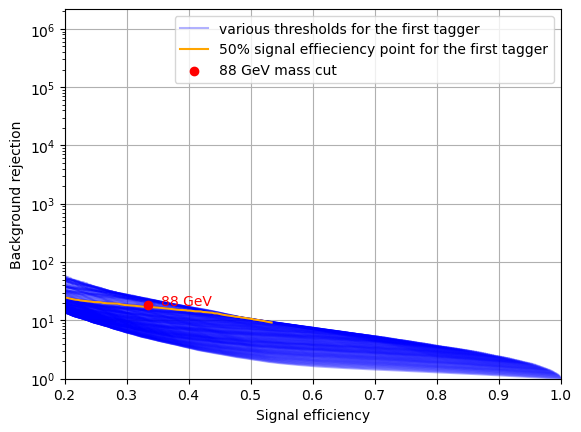

In [100]:
y_truth_only_Z_signal = np.array([1 if truth_particle=="W" else 0 for truth_particle in truth_particles])
y_truth_only_Z_signal = y_truth_only_Z_signal if mass_cut is None else y_truth_only_Z_signal[mass_cut]
trained_model = "LundNet on wide-mass W"
y_pred = models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]
fpr, tpr, thresholds = roc_curve(y_truth_only_Z_signal, y_pred_mass_cut, sample_weight=sample_weights_mass_cut)
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
fpr = fpr[indices]
tpr = tpr[indices]
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

for i,threshold_score in enumerate(thresholds):
    # Filter y_pred values greater than the threshold score
    y_truth_signal_jets = y_truth_only_Z_signal[y_pred_mass_cut > threshold_score]
    if len(y_truth_signal_jets) == 0:
        continue

    trained_model = "LundNet on W_Z"
    y_pred_WZ = 1-models[trained_model]["y_pred"]
    y_pred_WZ_mass_cut = y_pred_WZ if mass_cut is None else y_pred_WZ[mass_cut]
    y_pred_WZ_mass_cut = y_pred_WZ_mass_cut[y_pred_mass_cut > threshold_score]

    fpr_WZ, tpr_WZ, thresholds_WZ = roc_curve(y_truth_signal_jets, y_pred_WZ_mass_cut, sample_weight=sample_weights_mass_cut[y_pred_mass_cut > threshold_score])
    # Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
    indices = np.linspace(0, len(fpr_WZ) - 1, 200, dtype=int)
    fpr_WZ = fpr_WZ[indices]
    tpr_WZ = tpr_WZ[indices]
    thresholds_WZ = thresholds_WZ[indices]

    tpr_total = tpr_WZ * tpr[i]
    fpr_total = fpr_WZ * fpr[i]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        varied_score_cut_lines, = plt.plot(tpr_total, 1/fpr_total, label=f"{trained_model} (area = {roc_auc:.2f})" ,color="blue", alpha=0.3)
y_truth_W_signal = np.array([1 if truth_particle == "W" else 0 for truth_particle in truth_particles])
y_truth_W_signal_mass_cut = y_truth_W_signal if mass_cut is None else y_truth_W_signal[mass_cut]
tagged_as_signal = models["LundNet on wide-mass W"]["tagged_as_signal"] if mass_cut is None else models["LundNet on wide-mass W"]["tagged_as_signal"][mass_cut]

trained_model = "LundNet on W_Z"
y_pred = 1-models[trained_model]["y_pred"]
y_pred_mass_cut = y_pred if mass_cut is None else y_pred[mass_cut]


fpr, tpr, thresholds = roc_curve(y_truth_W_signal_mass_cut[tagged_as_signal], y_pred_mass_cut[tagged_as_signal], sample_weight=sample_weights_mass_cut[tagged_as_signal])
# Get 200 evenly spaced values from the arrays fpr, tpr, and thresholds
indices = np.linspace(0, len(fpr) - 1, 200, dtype=int)
sample_weights_mass_cut_tagged_as_signal = sample_weights_mass_cut[tagged_as_signal]
tpr_first_tagger = np.sum(sample_weights_mass_cut_tagged_as_signal[y_truth_W_signal_mass_cut[tagged_as_signal] == 1]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 1])
fpr_first_tagger = np.sum(sample_weights_mass_cut_tagged_as_signal[y_truth_W_signal_mass_cut[tagged_as_signal] == 0]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 0])
fpr = fpr[indices]*fpr_first_tagger
tpr = tpr[indices]*tpr_first_tagger
thresholds = thresholds[indices]
roc_auc = auc(fpr, tpr)

# Apply mass cut at 88 GeV
mass_cut_88 = mass < 88
mass_cut_88 = mass_cut_88 if mass_cut is None else mass_cut_88[mass_cut]

# Get labels for jets passing this cut
labels_at_mass_cut = y_truth_W_signal_mass_cut[mass_cut_88 & tagged_as_signal]
sample_weights_at_mass_cut = sample_weights_mass_cut[mass_cut_88 & tagged_as_signal]

# TPR = fraction of W (signal) jets selected
tpr_mass_cut = np.sum(sample_weights_at_mass_cut[labels_at_mass_cut == 1]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 1])
# FPR = fraction of Z (background) jets selected
tpr_mass_cut = np.sum(sample_weights_at_mass_cut[labels_at_mass_cut == 1]) / np.sum(sample_weights_mass_cut[y_truth_W_signal_mass_cut == 1])

#fpr_mass_cut = np.sum((mass < 88) & (truth_particles == "Z")) / np.sum(truth_particles == "Z")

sign_eff50_line, = plt.plot(tpr, 1/fpr, label=f"ROC (AUC = {roc_auc:.2f})", color="orange")
# random_line = plt.plot([0, 1], [0, 1], "--", color="black")

# Add the 88 GeV mass cut point
point_88 = plt.scatter(tpr_mass_cut, 1/fpr_mass_cut, color="red", label="88 GeV Mass Cut", zorder=5)
plt.text(tpr_mass_cut + 0.02, 1/fpr_mass_cut, "88 GeV", color="red")

plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.xlim([0.2, 1])
plt.ylim([1, None])
plt.yscale("log")
plt.legend(
    [varied_score_cut_lines, sign_eff50_line, point_88],
    ["various thresholds for the first tagger", "50% signal effieciency point for the first tagger", "88 GeV mass cut"],
    loc="upper right")
plt.grid(True)

plt.show()

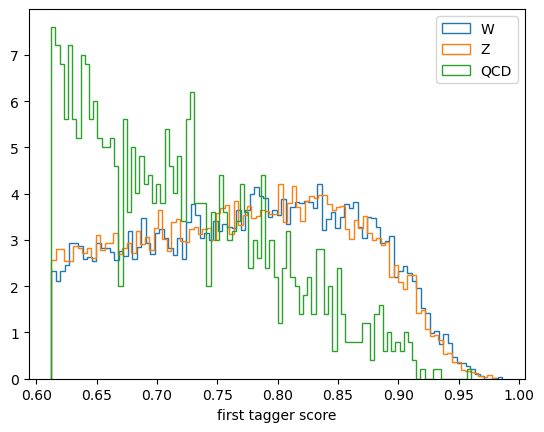

In [48]:
plt.hist(models["LundNet on wide-mass W"]["y_pred"][mass_cut][tagged_as_signal & (truth_particles_mass_cut=="W")], bins=100, histtype='step', label='W', density=True)
plt.hist(models["LundNet on wide-mass W"]["y_pred"][mass_cut][tagged_as_signal & (truth_particles_mass_cut=="Z")], bins=100, histtype='step', label='Z', density=True)
plt.hist(models["LundNet on wide-mass W"]["y_pred"][mass_cut][tagged_as_signal & (truth_particles_mass_cut=="QCD")], bins=100, histtype='step', label='QCD', density=True)
plt.legend()
plt.xlabel("first tagger score")
plt.show()

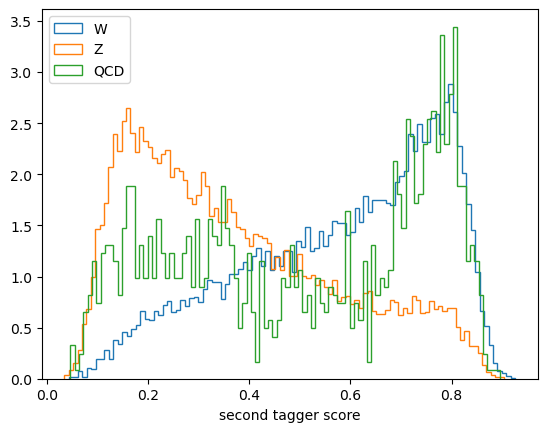

In [49]:
plt.hist(y_pred_mass_cut[tagged_as_signal & (truth_particles_mass_cut=="W")], bins=100, histtype='step', label='W', density=True)
plt.hist(y_pred_mass_cut[tagged_as_signal & (truth_particles_mass_cut=="Z")], bins=100, histtype='step', label='Z', density=True)
plt.hist(y_pred_mass_cut[tagged_as_signal & (truth_particles_mass_cut=="QCD")], bins=100, histtype='step', label='QCD', density=True)
plt.legend()
plt.xlabel("second tagger score")
plt.show()


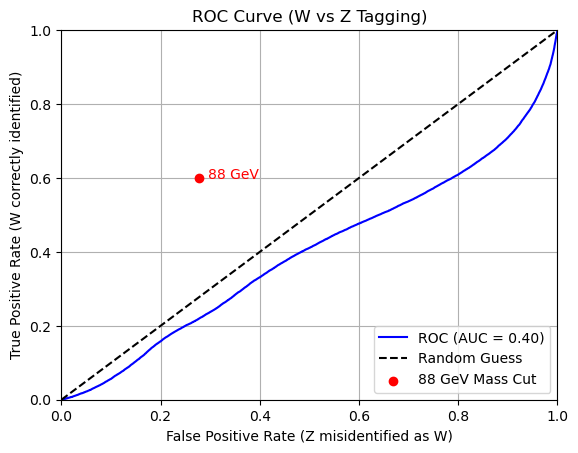

In [50]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# True labels: W = 1, Z = 0
y_truth_W_signal = np.array([1 if p == "W" else 0 for p in truth_particles])
y_pred = models["LundNet on W_Z"]["y_pred"]

# Compute ROC on full dataset
fpr, tpr, thresholds = roc_curve(y_truth_W_signal, y_pred)
roc_auc = auc(fpr, tpr)

# Compute 88 GeV mass cut point on full dataset
mass_cut_88 = mass < 88
labels_at_mass_cut = y_truth_W_signal[mass_cut_88]

tpr_mass_cut = np.sum(labels_at_mass_cut == 1) / np.sum(y_truth_W_signal == 1)
fpr_mass_cut = np.sum((mass < 88) & (np.array(truth_particles) == "Z")) / np.sum(np.array(truth_particles) == "Z")

# Plot
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "--", color="black", label="Random Guess")

plt.scatter(fpr_mass_cut, tpr_mass_cut, color="red", label="88 GeV Mass Cut", zorder=5)
plt.text(fpr_mass_cut + 0.02, tpr_mass_cut, "88 GeV", color="red")

plt.xlabel("False Positive Rate (Z misidentified as W)")
plt.ylabel("True Positive Rate (W correctly identified)")
plt.title("ROC Curve (W vs Z Tagging)")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.grid(True)
plt.show()



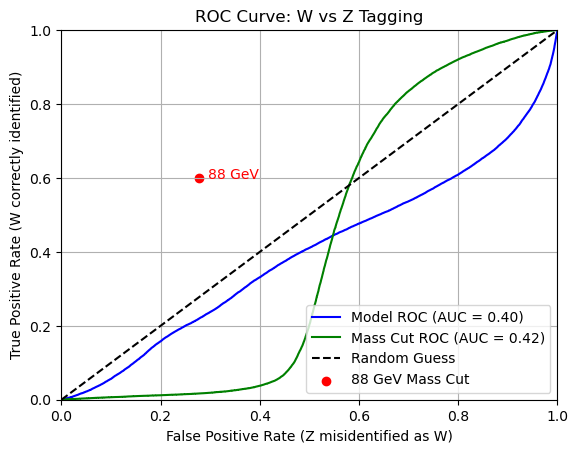

In [51]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels: W = 1, Z = 0
y_true = np.array([1 if p == "W" else 0 for p in truth_particles])

# Model predictions
y_pred_model = models["LundNet on W_Z"]["y_pred"]

# ROC from model
fpr_model, tpr_model, _ = roc_curve(y_true, y_pred_model)
roc_auc_model = auc(fpr_model, tpr_model)

# Use negative mass as "score" (since lower mass = more likely W)
y_score_mass = -mass  # So ROC works in the correct direction

# ROC from mass cut classifier
fpr_mass, tpr_mass, _ = roc_curve(y_true, y_score_mass)
roc_auc_mass = auc(fpr_mass, tpr_mass)

# Plot both curves
plt.plot(fpr_model, tpr_model, label=f"Model ROC (AUC = {roc_auc_model:.2f})", color="blue")
plt.plot(fpr_mass, tpr_mass, label=f"Mass Cut ROC (AUC = {roc_auc_mass:.2f})", color="green")
plt.plot([0, 1], [0, 1], "--", color="black", label="Random Guess")

# Optional: add specific point for mass = 88 GeV cut
mass_cut_point = 88
cut_mask = mass < mass_cut_point
labels_at_cut = y_true[cut_mask]

tpr_cut = np.sum(labels_at_cut == 1) / np.sum(y_true == 1)
fpr_cut = np.sum((mass < mass_cut_point) & (np.array(truth_particles) == "Z")) / np.sum(np.array(truth_particles) == "Z")

plt.scatter(fpr_cut, tpr_cut, color="red", label="88 GeV Mass Cut")
plt.text(fpr_cut + 0.02, tpr_cut, "88 GeV", color="red")

# Plot settings
plt.xlabel("False Positive Rate (Z misidentified as W)")
plt.ylabel("True Positive Rate (W correctly identified)")
plt.title("ROC Curve: W vs Z Tagging")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/tmp/ipykernel_24441/2633857725.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr_mass, 1/ fpr_mass, label=f"Mass Cut ROC (AUC = {roc_auc_mass:.2f})", color="green")


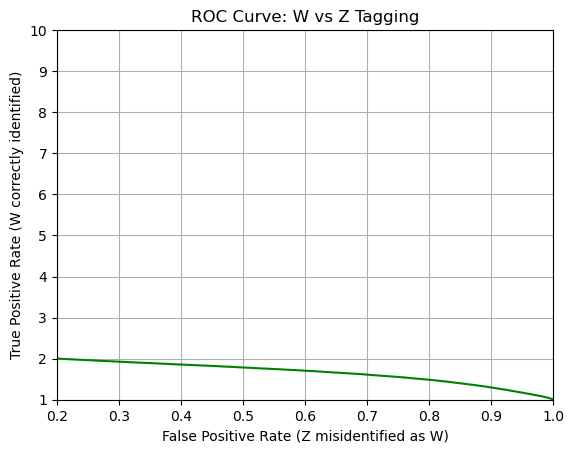

In [52]:

# Plot both curves#
#plt.plot(fpr_model, tpr_model, label=f"Model ROC (AUC = {roc_auc_model:.2f})", color="blue")
plt.plot(tpr_mass, 1/ fpr_mass, label=f"Mass Cut ROC (AUC = {roc_auc_mass:.2f})", color="green")
#plt.plot([0, 1], [0, 1], "--", color="black", label="Random Guess")


#plt.scatter(fpr_cut, tpr_cut, color="red", label="88 GeV Mass Cut")
#plt.text(fpr_cut + 0.02, tpr_cut, "88 GeV", color="red")

# Plot settings
plt.xlabel("False Positive Rate (Z misidentified as W)")
plt.ylabel("True Positive Rate (W correctly identified)")
plt.title("ROC Curve: W vs Z Tagging")
plt.xlim([0.2, 1])
plt.ylim([1, 10])
#plt.legend(loc="lower right")
plt.grid(True)
plt.show()